## Setup

In [ ]:
import cassiopeia as cas
import pandas as pd
import pickle as pic
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import pprint
import inverse_whd

# Base parameters, no fitness
in_folder = "/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/trees/exponential_plus_c/400cells/no_fit/char40/"
out_folder = "./benchmarking/"

: 

In [2]:
# Load config
with open("config.json") as f:
    config = json.load(f)

# IO Setup
out_folder = "./post_sim_analytics/"
in_tree_raw = config["tree_dir"]

# Options:
pprint.pprint(config)

{'fitness_regimes': ['no_fit'],
 'mutation_proportions': [0.01, 0.1, 0.5, 0.6, 0.7],
 'num_trees': 50,
 'numcassettes': [10, 20, 40, 100],
 'numcells': 400,
 'numstates': [1, 10, 50, 100],
 'seed_dir': '/home/eecs/ivalexander13/datadir/simulation_data/seeds/',
 'top_dir': '/home/eecs/ivalexander13/datadir/simulation_data/topologies/{topology}/{fitness_regime}/cells{numcells}/',
 'topologies': ['exponential_plus_c'],
 'tree_dir': '/home/eecs/ivalexander13/datadir/simulation_data/trees4/exponential_plus_c/no_fit/cells400/mutrate{mutation_proportions}/char{numcassettes}/states{numstates}/'}


In [3]:
# Helper getter
def get_pair(in_tree_raw, numtrees, **kwargs):
    if type(numtrees) is int:
        numtrees = [numtrees]
    
    dists_out = np.array([])
    dissim_out = np.array([])
    for numtree in numtrees:
        filename = in_tree_raw.format(**kwargs)

        dists = pic.load(open(filename + f'dists{numtree}.pkl', 'rb'))
        dissim = pic.load(open(filename + f'dissim_whd{numtree}.pkl', 'rb'))

        dists_out = np.append(dists_out, dists)
        dissim_out = np.append(dissim_out, dissim)

    return dists_out, dissim_out

get_pair(
    in_tree_raw, 
    numtrees=4,
    mutation_proportions=0.1, 
    numcassettes=20,
    numstates=1)

(array([1.29954804, 1.88194528, 0.76321912, ..., 1.88194528, 1.29954804,
        1.88194528]),
 array([0.15, 0.35, 0.1 , ..., 0.25, 0.25, 0.3 ]))

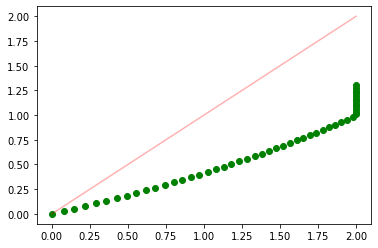

In [4]:
def draw_inv_whd(mutation_proportions, numcassettes, numstates, time=1):
    try:
        # state_distribution = pic.load(open(f"/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/priors/states{numstates}.pkl", "rb"))
        state_distribution = dict(enumerate([1 / numstates] * numstates, 1))
    except:
        return [0], [0]

    q = np.sum(np.array([*state_distribution.values()])**2)

    whds = np.linspace(0, 1.3, 50)
    iwhds = [2 * inverse_whd.ewhd_inv(
                num_sites=numcassettes, 
                mut_rate=np.log(1 - mutation_proportions)/(-1 * 1), 
                collision_rate=q, 
                whd=whd, 
                time=time, 
                error_tolerance=0.001
            ) for whd in whds]

    return whds, iwhds 

whds, iwhds = draw_inv_whd(0.5, 40, 100, time=1)
plt.scatter(iwhds, whds, c='green')
linx = np.linspace(0, 2)
plt.plot(linx, linx, 'red', alpha=0.3)
plt.show()

In [11]:
def plot_pair(title, axx, numtrees, 
        mutation_proportions, 
        numcassettes,
        numstates
        ):
    # Get Pair of Arrays
    dists, dissim = get_pair(
        in_tree_raw, 
        numtrees=numtrees,
        mutation_proportions=mutation_proportions, 
        numcassettes=numcassettes,
        numstates=numstates)
    # dists, dissim

    # Calculate Correlation
    corr = np.round(np.corrcoef(dissim, dists)[0, 1], 3)
    # print('Corr: ' + str(corr))

    # Calc MSE
    mse = np.round((np.square(dists - dissim)).mean(axis=None), 3)
    # print(f'MSE: {mse}')

    # Histogram of Dissimilarity Map Distances
    # plt.hist(dissim[dissim >-1], bins=100);
    # plt.title('Histogram of Dissimilarity Map Distances')
    # plt.show()
    # plt.clf()

    # Scatter Plot
    axx.scatter(x=dists, y=dissim, alpha=0.005)
    axx.set_title(f'{title}', fontweight="bold")
    axx.set(xlabel='True Distance', ylabel='WHD')
    linx = np.linspace(0, max(*dists, *dissim))
    liny = np.linspace(0, max(*dists, *dissim)/2)
    axx.plot(linx, liny, 'red', alpha=0.3)
    axx.text(0.05, 1.7, f"Corr {corr}\nMSE {mse}")
    try:
        whds, iwhds = draw_inv_whd(
            mutation_proportions=mutation_proportions,
            numcassettes=numcassettes,
            numstates=numstates,
            time=1
        )
        axx.plot(iwhds, whds, c='green')
        axx.set_xlim(0, 2)
        axx.set_ylim(0, 2)
    except:
        pass
    # axx.show()
    # axx.clf()


In [17]:
def plot_diffs(title, axx, numtrees, 
        mutation_proportions, 
        numcassettes,
        numstates
        ):
    # Get Pair of Arrays
    dists, dissim = get_pair(
        in_tree_raw, 
        numtrees=numtrees,
        mutation_proportions=mutation_proportions, 
        numcassettes=numcassettes,
        numstates=numstates)
    
    state_distribution = dict(enumerate([1 / numstates] * numstates, 1))
    q = np.sum(np.array([*state_distribution.values()])**2)
    
    iwhds = np.array([2 * inverse_whd.ewhd_inv(
                num_sites=numcassettes, 
                mut_rate=np.log(1 - mutation_proportions)/(-1 * 1), 
                collision_rate=q, 
                whd=whd, 
                time=1, 
                error_tolerance=0.001
            ) for whd in dissim])

    # Calculate Correlation
    corr = np.round(np.corrcoef(dissim, dists)[0, 1], 3)

    # Calc MSE
    mse = np.round((np.square(dists - dissim)).mean(axis=None), 3)

    # Sort for plot
    sorted_idx = dists.argsort()
    
    # Scatter Plot
    x = range(len(dists))
    axx.scatter(x, dists[sorted_idx], alpha=0.005, c='blue', label='True Distance')
    axx.scatter(x, dissim[sorted_idx], alpha=0.005, c='red', label='WHD')
    axx.scatter(x, iwhds[sorted_idx], alpha=0.005, c='green', label='iWHD')
    
    axx.set_title(f'{title}', fontweight="bold")
    axx.set(xlabel='Leaves', ylabel='Distance')


# Mutation Proportion

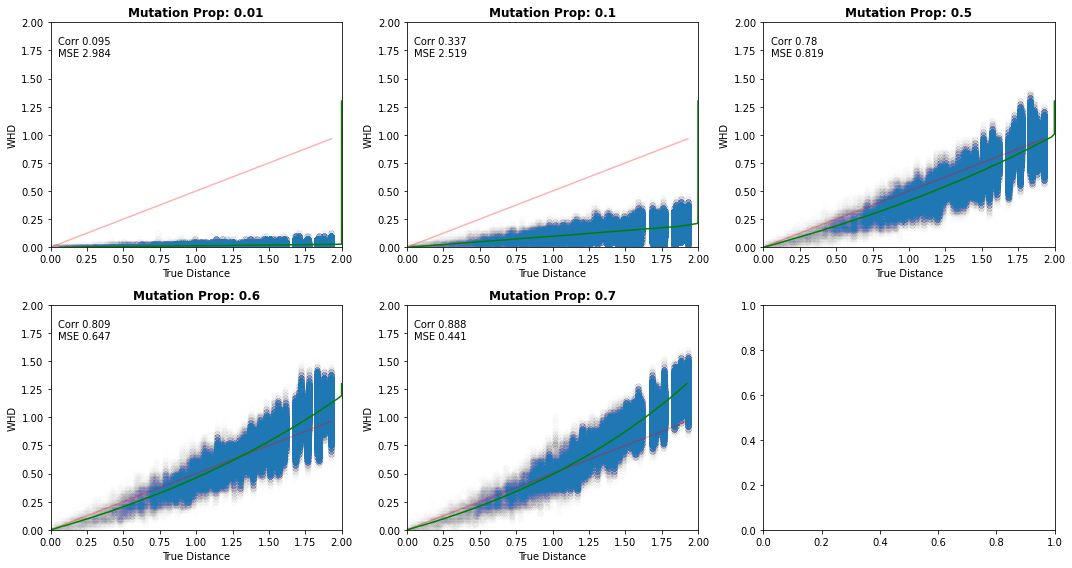

<Figure size 432x288 with 0 Axes>

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in zip(config['mutation_proportions'], axs.flat):
    plot_pair(
        title=f'Mutation Prop: {i}',
        axx=ax,
        numtrees=range(5),
        mutation_proportions=i, 
        numcassettes=40,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf();

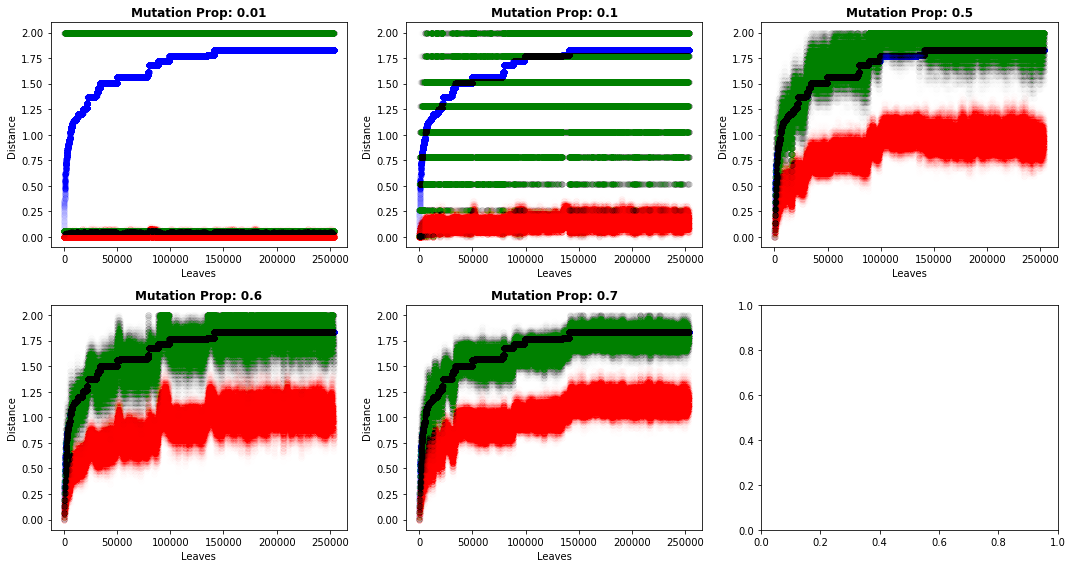

<Figure size 432x288 with 0 Axes>

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in zip(config['mutation_proportions'], axs.flat):
    plot_diffs(
        title=f'Mutation Prop: {i}',
        axx=ax,
        numtrees=range(1),
        mutation_proportions=i, 
        numcassettes=40,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

## Comparing NumCassettes


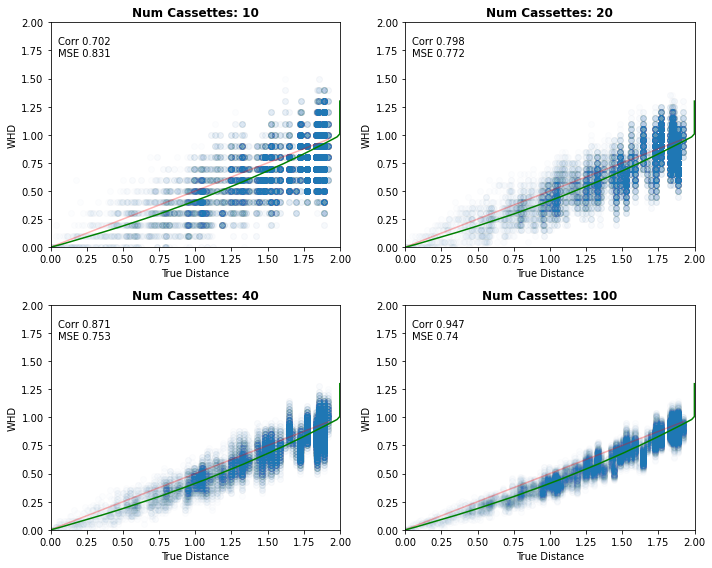

<Figure size 432x288 with 0 Axes>

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numcassettes'], axs.flat):
    plot_pair(
        title=f'Num Cassettes: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=i,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

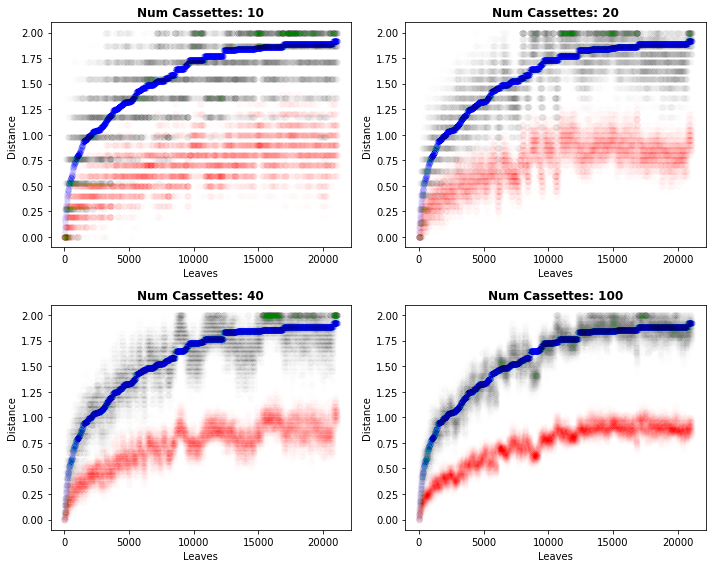

<Figure size 432x288 with 0 Axes>

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numcassettes'], axs.flat):
    plot_diffs(
        title=f'Num Cassettes: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=i,
        numstates=100)

plt.tight_layout()
plt.show()
plt.clf()

## Across NumStates

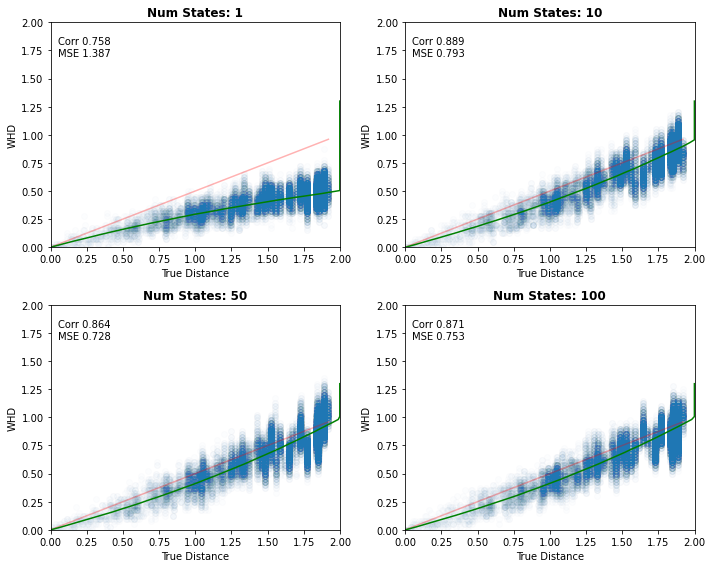

<Figure size 432x288 with 0 Axes>

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numstates'], axs.flat):
    plot_pair(
        title=f'Num States: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=40,
        numstates=i)

plt.tight_layout()
plt.show()
plt.clf()

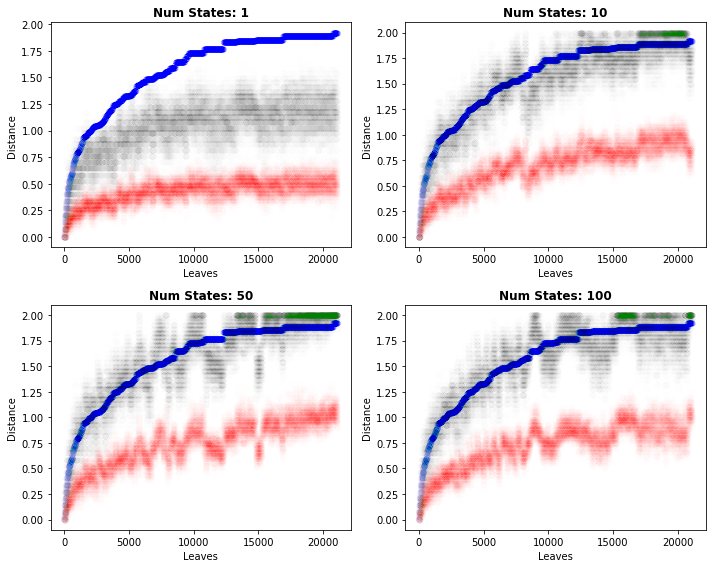

<Figure size 432x288 with 0 Axes>

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in zip(config['numstates'], axs.flat):
    plot_diffs(
        title=f'Num States: {i}',
        axx=ax,
        numtrees=range(12),
        mutation_proportions=0.5, 
        numcassettes=40,
        numstates=i)

plt.tight_layout()
plt.show()
plt.clf()